In [5]:
#!/usr/bin/env python

'''
Feature-based image matching sample.

Note, that you will need the https://github.com/opencv/opencv_contrib repo for SIFT and SURF

USAGE
  find_obj.py [--feature=<sift|surf|orb|akaze|brisk>[-flann]] [ <image1> <image2> ]

  --feature  - Feature to use. Can be sift, surf, orb or brisk. Append '-flann'
               to feature name to use Flann-based matcher instead bruteforce.

  Press left mouse button on a feature point to see its matching point.
'''

# Python 2/3 compatibility
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from common import anorm, getsize

FLANN_INDEX_KDTREE = 1  # bug: flann enums are missing
FLANN_INDEX_LSH    = 6


def init_feature(name):
    chunks = name.split('-')
    if chunks[0] == 'sift':
        detector = cv.xfeatures2d.SIFT_create()
        norm = cv.NORM_L2
    elif chunks[0] == 'surf':
        detector = cv.xfeatures2d.SURF_create(800)
        norm = cv.NORM_L2
    elif chunks[0] == 'orb':
        detector = cv.ORB_create(400)
        norm = cv.NORM_HAMMING
    elif chunks[0] == 'akaze':
        detector = cv.AKAZE_create()
        norm = cv.NORM_HAMMING
    elif chunks[0] == 'brisk':
        detector = cv.BRISK_create()
        norm = cv.NORM_HAMMING
    else:
        return None, None
    if 'flann' in chunks:
        if norm == cv.NORM_L2:
            flann_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        else:
            flann_params= dict(algorithm = FLANN_INDEX_LSH,
                               table_number = 6, # 12
                               key_size = 12,     # 20
                               multi_probe_level = 1) #2
        matcher = cv.FlannBasedMatcher(flann_params, {})  # bug : need to pass empty dict (#1329)
    else:
        matcher = cv.BFMatcher(norm)
    return detector, matcher


def filter_matches(kp1, kp2, matches, ratio = 0.75):
    mkp1, mkp2 = [], []
    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            m = m[0]
            mkp1.append( kp1[m.queryIdx] )
            mkp2.append( kp2[m.trainIdx] )
    p1 = np.float32([kp.pt for kp in mkp1])
    p2 = np.float32([kp.pt for kp in mkp2])
    kp_pairs = zip(mkp1, mkp2)
    return p1, p2, list(kp_pairs)

def explore_match(win, img1, img2, kp_pairs, status = None, H = None):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    vis = np.zeros((max(h1, h2), w1+w2), np.uint8)
    vis[:h1, :w1] = img1
    vis[:h2, w1:w1+w2] = img2
    vis = cv.cvtColor(vis, cv.COLOR_GRAY2BGR)

    if H is not None:
        corners = np.float32([[0, 0], [w1, 0], [w1, h1], [0, h1]])
        corners = np.int32( cv.perspectiveTransform(corners.reshape(1, -1, 2), H).reshape(-1, 2) + (w1, 0) )
        cv.polylines(vis, [corners], True, (255, 255, 255))

    if status is None:
        status = np.ones(len(kp_pairs), np.bool_)
    p1, p2 = [], []  # python 2 / python 3 change of zip unpacking
    for kpp in kp_pairs:
        p1.append(np.int32(kpp[0].pt))
        p2.append(np.int32(np.array(kpp[1].pt) + [w1, 0]))

    green = (0, 255, 0)
    red = (0, 0, 255)
    kp_color = (51, 103, 236)
    for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
        if inlier:
            col = green
            cv.circle(vis, (x1, y1), 2, col, -1)
            cv.circle(vis, (x2, y2), 2, col, -1)
        else:
            col = red
            r = 2
            thickness = 3
            cv.line(vis, (x1-r, y1-r), (x1+r, y1+r), col, thickness)
            cv.line(vis, (x1-r, y1+r), (x1+r, y1-r), col, thickness)
            cv.line(vis, (x2-r, y2-r), (x2+r, y2+r), col, thickness)
            cv.line(vis, (x2-r, y2+r), (x2+r, y2-r), col, thickness)
    vis0 = vis.copy()
    for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
        if inlier:
            cv.line(vis, (x1, y1), (x2, y2), green)

    return vis


def detect(feature_name,fn1, fn2):

    img1 = cv.imread(fn1, 0)
    img2 = cv.imread(fn2, 0)
    detector, matcher = init_feature(feature_name)

    print('using', feature_name)

    kp1, desc1 = detector.detectAndCompute(img1, None)
    kp2, desc2 = detector.detectAndCompute(img2, None)
    print('img1 - %d features, img2 - %d features' % (len(kp1), len(kp2)))

    def match_and_draw(win):
        print('matching...')
        raw_matches = matcher.knnMatch(desc1, trainDescriptors = desc2, k = 2) #2
        p1, p2, kp_pairs = filter_matches(kp1, kp2, raw_matches)
        if len(p1) >= 4:
            H, status = cv.findHomography(p1, p2, cv.RANSAC, 5.0)
            print('%d / %d  inliers/matched' % (np.sum(status), len(status)))
        else:
            H, status = None, None
            print('%d matches found, not enough for homography estimation' % len(p1))

        vis = explore_match(win, img1, img2, kp_pairs, status, H)
        return vis

    return match_and_draw('find_obj')

using sift
img1 - 603 features, img2 - 969 features
matching...
74 / 79  inliers/matched


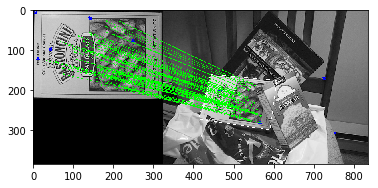

using sift-flann
img1 - 603 features, img2 - 969 features
matching...
73 / 79  inliers/matched


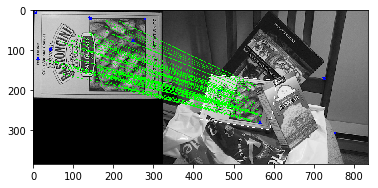

using surf
img1 - 588 features, img2 - 762 features
matching...
48 / 57  inliers/matched


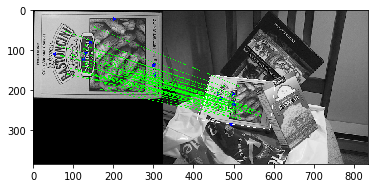

using surf-flann
img1 - 588 features, img2 - 762 features
matching...
48 / 60  inliers/matched


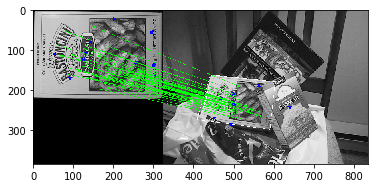

using orb
img1 - 366 features, img2 - 400 features
matching...
22 / 24  inliers/matched


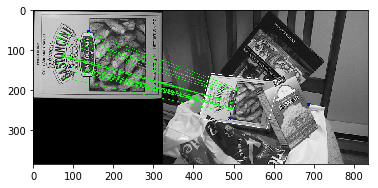

using orb-flann
img1 - 366 features, img2 - 400 features
matching...
21 / 28  inliers/matched


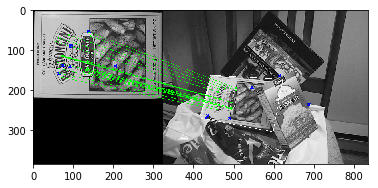

using akaze
img1 - 383 features, img2 - 795 features
matching...
22 / 24  inliers/matched


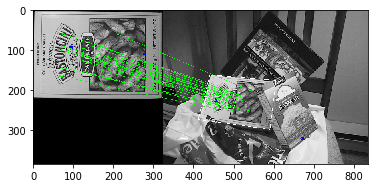

using akaze-flann
img1 - 383 features, img2 - 795 features
matching...
23 / 31  inliers/matched


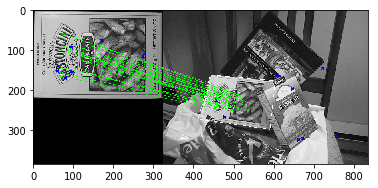

using brisk
img1 - 1662 features, img2 - 2786 features
matching...
50 / 52  inliers/matched


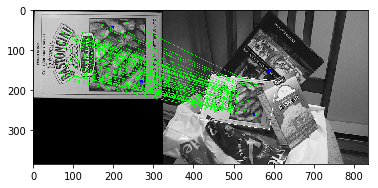

using brisk-flann
img1 - 1662 features, img2 - 2786 features
matching...
52 / 57  inliers/matched


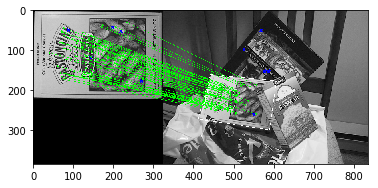

In [9]:
#[--feature=<sift|surf|orb|akaze|brisk>[-flann]]
resultado = detect('sift','box.png','box_in_scene.png')
plt.imshow(resultado,cmap = 'gray')
plt.show()
resultado = detect('sift-flann','box.png','box_in_scene.png')
plt.imshow(resultado,cmap = 'gray')
plt.show()
resultado = detect('surf','box.png','box_in_scene.png')
plt.imshow(resultado,cmap = 'gray')
plt.show()
resultado = detect('surf-flann','box.png','box_in_scene.png')
plt.imshow(resultado,cmap = 'gray')
plt.show()
resultado = detect('orb','box.png','box_in_scene.png')
plt.imshow(resultado,cmap = 'gray')
plt.show()
resultado = detect('orb-flann','box.png','box_in_scene.png')
plt.imshow(resultado,cmap = 'gray')
plt.show()
resultado = detect('akaze','box.png','box_in_scene.png')
plt.imshow(resultado,cmap = 'gray')
plt.show()
resultado = detect('akaze-flann','box.png','box_in_scene.png')
plt.imshow(resultado,cmap = 'gray')
plt.show()
resultado = detect('brisk','box.png','box_in_scene.png')
plt.imshow(resultado,cmap = 'gray')
plt.show()
resultado = detect('brisk-flann','box.png','box_in_scene.png')
plt.imshow(resultado,cmap = 'gray')
plt.show()